In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv
/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/349_IM-1697-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/607_IM-2196-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2832_IM-1249-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/699_IM-2263-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1931_IM-0602-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/947_IM-2442-2001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2932_IM-1335-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/2303_IM-0882-1001.dcm.png
/kaggle/input/chest-xrays-indiana-university/images/images_normalized/291_IM-1313-2001.dcm.png
/kaggle

In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2  # For image handling
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import os

# Load data
# Adjust the file paths as needed for your environment
df_projections = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df_reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Display basic information about the data to confirm successful loading
print("Projections DataFrame Head:")
print(df_projections.head())

print("\nReports DataFrame Head:")
print(df_reports.head())

# Check the number of images in the directory (assuming images are in a folder called 'images/')
image_folder_path = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'  # Update this path if your images are in a different location
image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.png')]

print(f"\nNumber of images found: {len(image_files)}")


Projections DataFrame Head:
   uid                filename projection
0    1  1_IM-0001-4001.dcm.png    Frontal
1    1  1_IM-0001-3001.dcm.png    Lateral
2    2  2_IM-0652-1001.dcm.png    Frontal
3    2  2_IM-0652-2001.dcm.png    Lateral
4    3  3_IM-1384-1001.dcm.png    Frontal

Reports DataFrame Head:
   uid                                               MeSH  \
0    1                                             normal   
1    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
2    3                                             normal   
3    4  Pulmonary Disease, Chronic Obstructive;Bullous...   
4    5  Osteophyte/thoracic vertebrae/multiple/small;T...   

                                            Problems  \
0                                             normal   
1                      Cardiomegaly;Pulmonary Artery   
2                                             normal   
3  Pulmonary Disease, Chronic Obstructive;Bullous...   
4                         Osteophyte;Thickening;

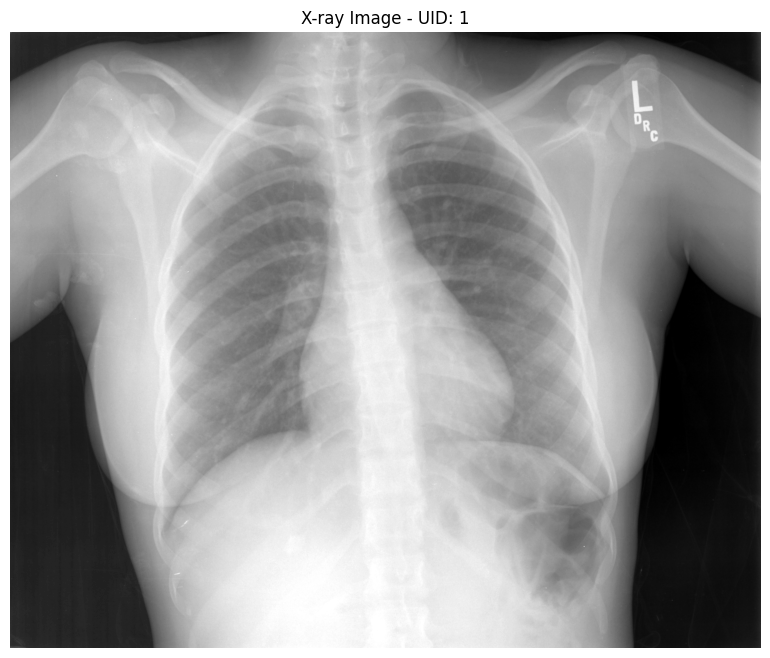

Findings:
The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.

Impression:
Normal chest x-XXXX.


In [3]:
# Function to display an X-ray image with its corresponding report
def display_sample_image_and_report(image_folder_path, df_projections, df_reports, sample_uid=1):
    # Filter the DataFrame to get the filename for the sample UID
    sample_projection = df_projections[df_projections['uid'] == sample_uid]
    
    if not sample_projection.empty:
        filename = sample_projection.iloc[0]['filename']
        image_path = os.path.join(image_folder_path, filename)
        
        # Read and display the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            plt.figure(figsize=(10, 8))
            plt.imshow(image, cmap='gray')
            plt.title(f"X-ray Image - UID: {sample_uid}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Image {filename} not found.")
        
        # Get and display the corresponding report
        sample_report = df_reports[df_reports['uid'] == sample_uid]
        if not sample_report.empty:
            findings = sample_report.iloc[0]['findings']
            impression = sample_report.iloc[0]['impression']
            
            print("Findings:")
            print(findings if pd.notnull(findings) else "No findings available.")
            print("\nImpression:")
            print(impression if pd.notnull(impression) else "No impression available.")
        else:
            print(f"No report found for UID: {sample_uid}")
    else:
        print(f"No image found for UID: {sample_uid}")

# Path to the images folder
image_folder_path = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'  # Update this path if necessary

# Display a sample image and report for UID 1
display_sample_image_and_report(image_folder_path, df_projections, df_reports, sample_uid=1)
